<h3>Part 1 -- Autoencoder </h3>
<h5>Each MNIST image is 28 X 28 X 1. This will be compressed to 4 X 4 X 4 using an autoencoder (784 variables to 64 variables).</h5>

In [1]:
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, Sequential, load_model

import copy
import matplotlib.pyplot as plt
import numpy as np
from autoencoder_utils import *

(X_train, _), (X_test, _) = mnist.load_data()

X_train = np.reshape(X_train, (len(X_train), 28, 28, 1)) / 255.
X_test = np.reshape(X_test, (len(X_test), 28, 28, 1)) / 255.


Using TensorFlow backend.


In [ ]:
autoencoder = Sequential()

input_shape = (28, 28, 1)
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=input_shape))
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(MaxPooling2D((2, 2)))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(MaxPooling2D((2, 2)))
autoencoder.add(Conv2D(4, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(MaxPooling2D((2, 2), padding='same')) #padding=same here, to maxpool 7*7 to 4*4
autoencoder.add(Conv2D(4, (1, 1), activation='sigmoid', padding='same', name='encoded_layer')) #sigmoid to convert all to values between 0 and 1, for comparison later on using binary_crossentropy
#at this point, encoded layer has shape (4, 4, 4)

autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal'))  #no padding=same here, to convert 16*16 to 14*14
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_crossentropy'])

In [ ]:
epochs = 30
batch_size = 128

autoencoder.fit(X_train, X_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_test, X_test))

In [2]:
# from h5py import h5py

# autoencoder.save('autoencoder_MNIST.h5')
# autoencoder = load_model('autoencoder_MNIST_final.h5')

<h5>
The code below displays the original and autoencoded versions of 10 images.
<br>
They look pretty similar
</h5>

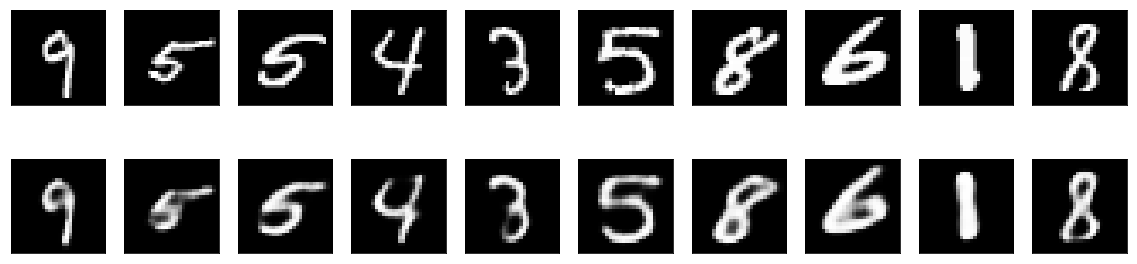

In [6]:
n = 10
img_to_show_idx = np.random.choice(range(X_test.shape[0]), n, replace=False)
X_test_to_show = X_test[img_to_show_idx]
aft_autoencode = autoencoder.predict(X_test_to_show)

fig = plt.figure(figsize=(n*2, 5))
plt.gray()
img_shape = (28, 28)

for i in range(n):
    #display original
    display_single_subplot(X_test_to_show[i].reshape(img_shape), n_row=2, n_col=n, cell_num=i+1)
    #display aft autoencoding
    display_single_subplot(aft_autoencode[i].reshape(img_shape), n_row=2, n_col=n, cell_num=n+i+1)

plt.show()

<h3>
Part 2 -- selecting similar images
</h3>
<h5>
Given an image, select the most similar and dissimilar images, using binary cross entropy to determine similarity
</h5>

In [7]:
#find images similar to the image at this index
img_to_find_idx = 0

layer_name = 'encoded_layer'
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)

similarity_sorted = get_sorted_similarity_idx(encoder, img_to_find_idx, dataset=X_test, loss='binary_crossentropy')

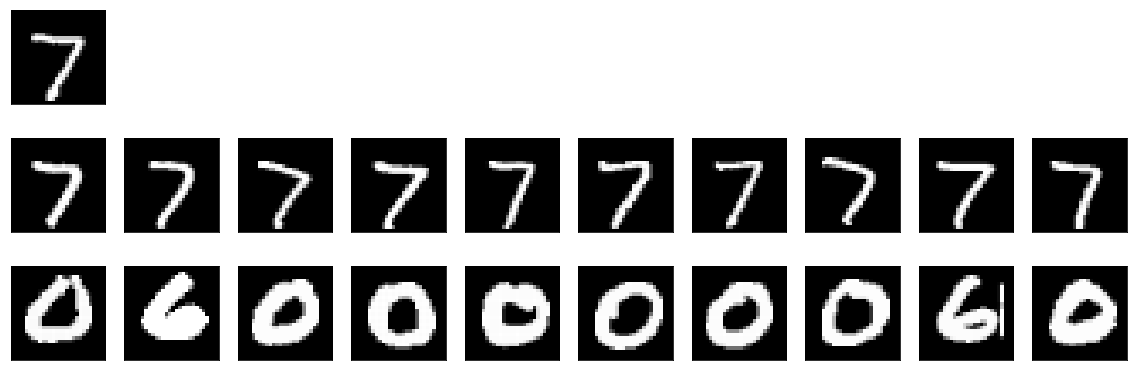

In [8]:
#show original image, n most similar images, n most dissimilar images
n = 10
image_dataset = X_test

plt.figure(figsize=(n*2, n/1.5))
img_shape = (28,28)

#display original
display_single_subplot(image_dataset[img_to_find_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=1)

# #display most similar
for i in range(n):
    similar_idx = similarity_sorted[i]
    display_single_subplot(image_dataset[similar_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=n+i+1)

# #display most dissimilar
for i in range(n):
    dissimilar_idx = similarity_sorted[-i-1]
    display_single_subplot(image_dataset[dissimilar_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=2*n+i+1)

plt.show()

<h5>Check if this result can handle rotations, shifts, rescaling etc.</h5>

In [34]:
#generate dataset of 21 images - 1 original image, 10 images augmented from the original image, 10 images randomly selected from dataset
from keras.preprocessing.image import ImageDataGenerator

#generate n modified images of an image, append n randomly selected image
img_to_test_index = 0
image_dataset = X_test
n=10

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15
    )
datagen.fit(image_dataset)

selected_images = np.zeros((2*n+1,28,28,1))
selected_images[0] = image_dataset[img_to_test_index]

for i in range(n):
    for _, img in enumerate(datagen.flow(image_dataset[img_to_test_index].reshape(1,28,28,1), batch_size=1)):
        selected_images[i+1] = copy.deepcopy(img)
        break

random_selected_img_idx = np.random.choice(image_dataset.shape[0], 10, replace=False)
for i, img_idx in enumerate(random_selected_img_idx):
    selected_images[n+1+i] = (image_dataset[img_idx])


In [35]:
layer_name = 'encoded_layer'
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)

similarity_sorted = get_sorted_similarity_idx(encoder, 0, dataset=selected_images, loss='binary_crossentropy')

<h5>
Here, we arrange the 20 images (10 augmented from the original image, 10 randomly selected from the wider pool of images), arranged by how similar they are to the original image.
<br><br>
The modified images are mostly deemed to be similar to the original image.
<br><br>
Modified images deemed to be dissimilar have mostly undergone a significant height/width shift. This is to be expected, since we're essentially comparing all pixels to each other, rather than objects in the image (the digit, in this case.)
</h5>

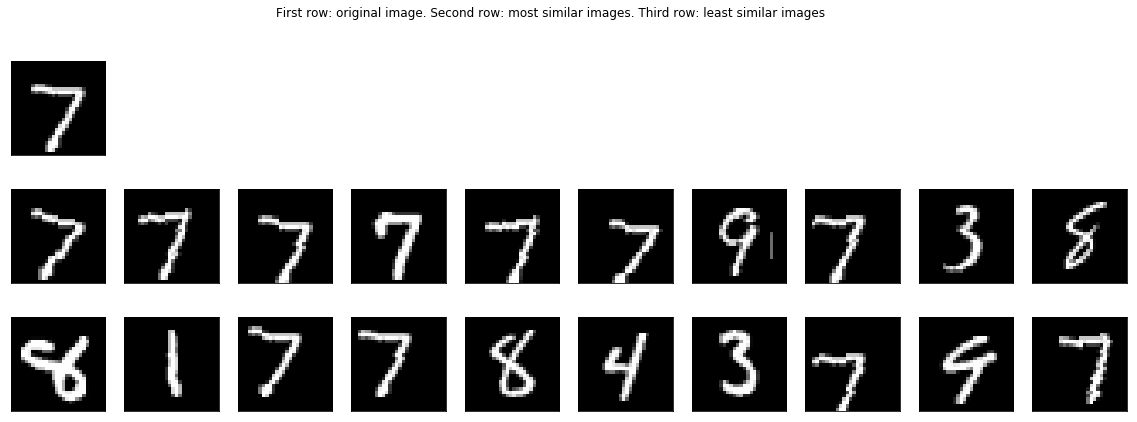

In [36]:
fig = plt.figure(figsize=(n*2, n/1.5))
fig.suptitle('First row: original image. Second row: most similar images. Third row: least similar images')

img_shape = (28, 28)
#display original
display_single_subplot(selected_images[0].reshape(img_shape), n_row=3, n_col=n, cell_num=1)

#display most similar
for i in range(n):
    similar_idx = similarity_sorted[i]
    display_single_subplot(selected_images[similar_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=n+i+1)
    
#display most dissimilar
for i in range(n):
    dissimilar_idx = similarity_sorted[-i-1]
    display_single_subplot(selected_images[dissimilar_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=2*n+i+1)

plt.show()

<h5>Compare to 'baseline', binary cross entropy comparison of original image pixels.</h5>

In [39]:
import tensorflow as tf
from keras.losses import binary_crossentropy, cosine_proximity

img_to_find_idx = 0
dataset = copy.deepcopy(X_test)
dataset = dataset.reshape(dataset.shape[0], -1)
#initializing vars to pass into tensorflow
X_selected = [dataset[img_to_find_idx].tolist() for _ in range(dataset.shape[0])]
X_all = dataset.tolist()

X_selected_tf = tf.Variable(X_selected, tf.float32)
X_all_tf = tf.Variable(X_all, tf.float32)
loss_tf = binary_crossentropy(X_selected_tf, X_all_tf)
init_op = tf.global_variables_initializer()

similarity = []
with tf.Session() as sess:
    sess.run(init_op)
    similarity = sess.run(loss_tf)
similarity_sorted = np.argsort(np.array(similarity))[1:] #the same figure appears in X_all too, so remove it

<h5>Same digits are deemed to be more similar.</h5>

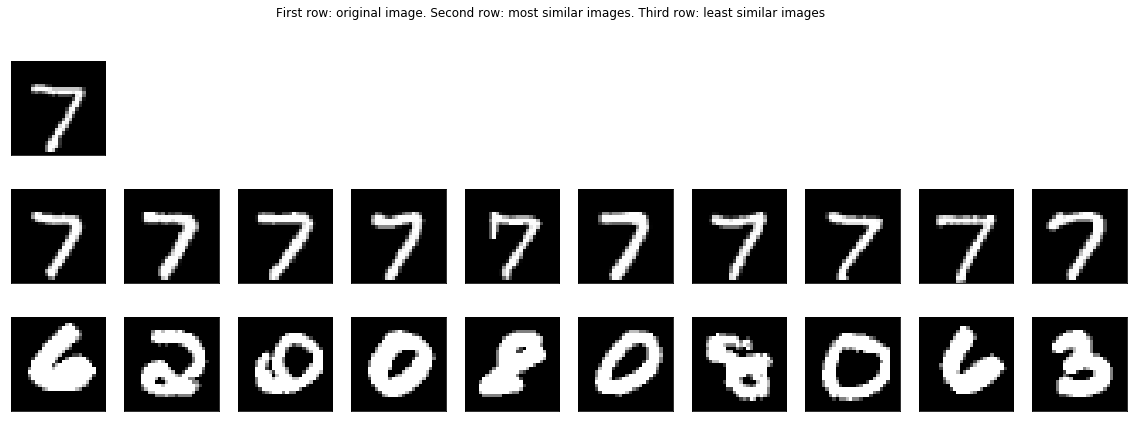

In [40]:
n=10
fig = plt.figure(figsize=(n*2, n/1.5))
plt.gray()
fig.suptitle('First row: original image. Second row: most similar images. Third row: least similar images')

img_shape = (28, 28)

#display original
display_single_subplot(X_test[img_to_find_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=1)
#display most similar
for i in range(n):
    similar_idx = similarity_sorted[i]
    display_single_subplot(X_test[similar_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=n+i+1)
    
#display most dissimilar
for i in range(n):
    dissimilar_idx = similarity_sorted[-i-1]
    display_single_subplot(X_test[dissimilar_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=2*n+i+1)

plt.show()